In [1]:
%load_ext autoreload
%autoreload 2

In [21]:
import sys
sys.path.append("..")

import pickle
import torch

import matplotlib.pyplot as plt
import numpy as np
from cebra.data import DatasetxCEBRA, ContrastiveMultiObjectiveLoader
import cebra
from cebra.data import TensorDataset

from cebra.solver import MultiObjectiveConfig
from cebra.solver.schedulers import LinearRampUp
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import TimeSeriesSplit


# Load the data & create dataset

In [3]:
file = "data/cynthi_neurons100_gridbase0.5_gridmodules2_grid_head_direction_place_speed_duration2000_noise0.0_bs100_seed231209234.p"
with open(file, 'rb') as f:
    dataset = pickle.load(f)

neural = torch.FloatTensor(dataset['spikes']).float()
position = torch.FloatTensor(dataset['position']).float()
ground_truth_attribution = dataset['ground_truth_attribution']
# create dataset
data = DatasetxCEBRA(
    neural, 
    position=position
)

## Visualize neural data and position

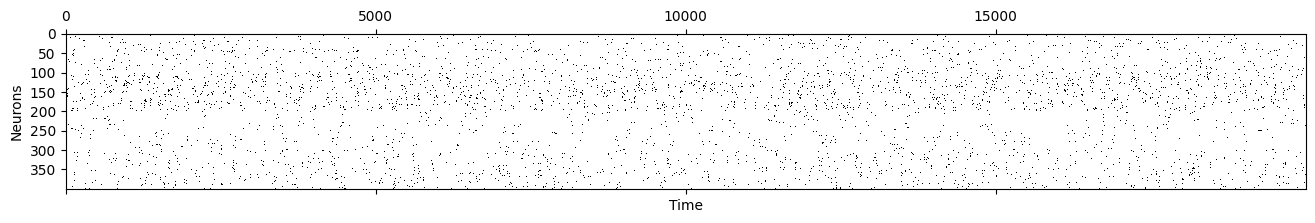

In [4]:
plt.matshow(neural.T, aspect="auto", cmap="Greys")
plt.ylabel("Neurons")
plt.xlabel("Time")
plt.show()

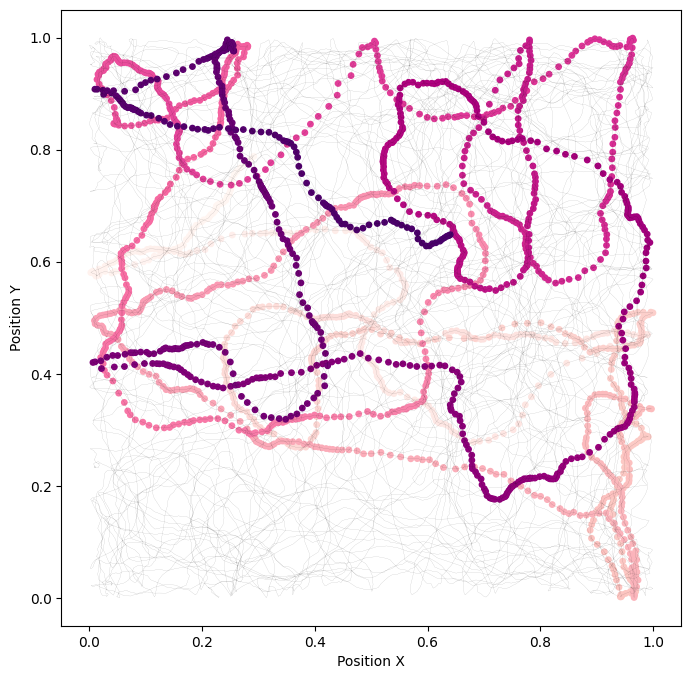

In [5]:
plt.figure(figsize=(8, 8))  # Set a larger figure size
traj_to = 2000
highlight_range = slice(250, 260)
plt.plot(position[0::,0], position[0::,1], 'k', linewidth=0.1, alpha=0.45)
cl = plt.scatter(position[0:traj_to,0], position[0:traj_to,1], c=np.arange(0, traj_to), cmap='RdPu', s=15)
plt.xlabel('Position X')
plt.ylabel('Position Y')
plt.show()

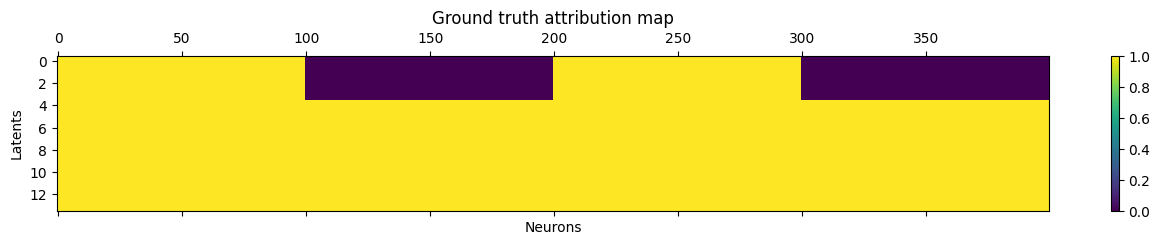

In [6]:
plt.matshow(dataset['ground_truth_attribution'], aspect="auto")
plt.title("Ground truth attribution map")
plt.xlabel("Neurons")
plt.ylabel("Latents")
plt.colorbar()
plt.show()

# Train a model

### 1. Define parameters

In [7]:
behavior_indices = (0, 4)
time_indices = (0, 14)

num_steps = 10_000
device = "cuda"
n_latents = 14

### 2. Define loader, model and solver

In [8]:
loader = ContrastiveMultiObjectiveLoader(dataset=data,
                                         num_steps=num_steps,
                                         batch_size=2_500).to(device)
config = MultiObjectiveConfig(loader)

config.set_slice(*behavior_indices)
config.set_loss("FixedCosineInfoNCE", temperature=1.)
config.set_distribution("time_delta", time_delta=1, label_name="position")
config.push()

config.set_slice(*time_indices)
config.set_loss("FixedCosineInfoNCE", temperature=1.)
config.set_distribution("time", time_offset=10)
config.push()

config.finalize()

criterion = config.criterion
feature_ranges = config.feature_ranges


neural_model = cebra.models.init(
    name="offset10-model",
    num_neurons=data.neural.shape[1],
    num_units=256,
    num_output=n_latents,
).to(device)

data.configure_for(neural_model)

opt = torch.optim.Adam(
    list(neural_model.parameters()) + list(criterion.parameters()),
    lr=3e-4,
    weight_decay=0,
) 

regularizer = cebra.models.jacobian_regularizer.JacobianReg()

solver = cebra.solver.init(
    name="multiobjective-solver",
    model=neural_model,
    feature_ranges=feature_ranges,
    regularizer = regularizer,
    renormalize=True,
    use_sam=False,
    criterion=criterion,
    optimizer=opt,
    tqdm_on=True,
).to(device)

Adding configuration for slice: (0, 4)
Adding configuration for slice: (0, 14)
Adding distribution of slice: (0, 4)
Adding distribution of slice: (0, 14)
Creating MultiCriterion
Computing renormalize ranges...
New ranges: [slice(0, 4, None), slice(4, 14, None)]


### 3. Define weight scheduler for regularizer and train model

In [9]:
weight_scheduler = LinearRampUp(
    n_splits=2,
    step_to_switch_on_reg= num_steps // 4,
    step_to_switch_off_reg= num_steps // 2,
    start_weight=0.,
    end_weight=0.1, 
)

solver.fit(loader=loader,
           valid_loader=None,
           log_frequency=None,
           scheduler_regularizer = weight_scheduler,
           scheduler_loss = None,
)

  0%|          | 0/10000 [00:00<?, ?it/s]

/home/paperspace/miniconda3/envs/xcebra/lib/python3.10/site-packages/torch/nn/modules/conv.py:306: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv1d(input, weight, bias, self.stride,
sum_loss_train: 13.127:  25%|██▍       | 2498/10000 [01:50<05:33, 22.51it/s]/home/paperspace/Documents/other/CEBRA-dev/examples/../cebra/models/jacobian_regularizer.py:72: UserWarning: This overload of addcdiv is deprecated:
	addcdiv(Tensor input, Number value, Tensor tensor1, Tensor tensor2, *, Tensor out)
Consider using one of the following signatures instead:
	addcdiv(Tensor input, Tensor tensor1, Tensor tensor2, *, Number value, Tensor out) (Triggered internally at ../torch/csrc/utils/python_arg_parser.cpp:1578.)
  v = torch.addcdiv(arxilirary_zero, 1.0, v, vnorm)
/home/paperspace/miniconda3/envs/xcebra

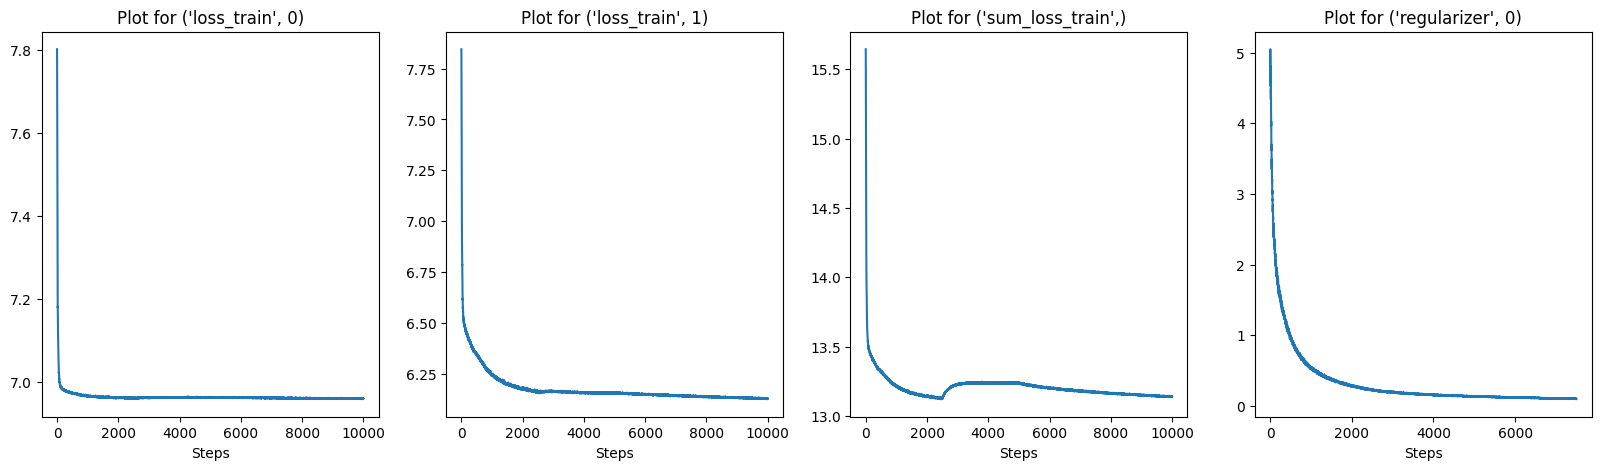

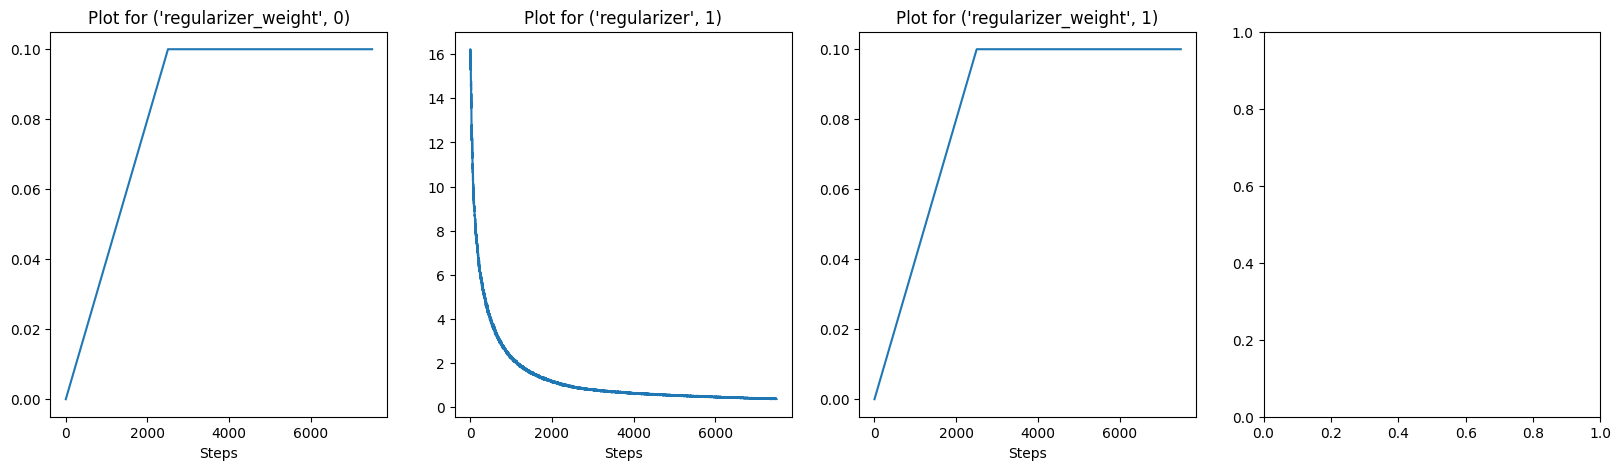

In [10]:
# Plot every key in solver.log
keys = list(solver.log.keys())
for i in range(0, len(keys), 4):
    fig, axs = plt.subplots(1, 4, figsize=(20, 5))
    for j, key in enumerate(keys[i:i+4]):
        axs[j].plot(solver.log[key])
        axs[j].set_title(f"Plot for {key}")
        axs[j].set_xlabel("Steps")
        # axs[j].set_ylabel("Value")
    plt.show()

# Compute embedding

In [15]:
type(neural)

torch.Tensor

In [16]:
data_emb = TensorDataset(neural, continuous=torch.zeros(len(data.neural)))
data_emb.configure_for(solver.model)
data_emb = data_emb[torch.arange(len(data_emb))]

solver.model.split_outputs = False
embedding = solver.model(data_emb.to(device)).detach().cpu()

/home/paperspace/miniconda3/envs/xcebra/lib/python3.10/site-packages/torch/nn/modules/conv.py:306: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv1d(input, weight, bias, self.stride,


## Compute R2 / KNN score 

In [17]:
time_indices_for_score = slice(4, 14)

In [18]:
X_behavior = embedding[:, slice(*behavior_indices)]
X_time = embedding[:, time_indices_for_score]
y = position

# Linear regression
linear_model_time = LinearRegression()
R2_time = linear_model_time.fit(X_time, y).score(X_time, y)

linear_model_behavior = LinearRegression()
R2_behavior = linear_model_behavior.fit(X_behavior, y).score(X_behavior, y)

print(f"R2 time: {R2_time: .2f}")
print(f"R2 behavior: {R2_behavior: .2f}")

R2 time:  0.15
R2 behavior:  0.79


In [22]:
tscv = TimeSeriesSplit(n_splits=5)
knn_model_time = KNeighborsRegressor()
knn_model_behavior = KNeighborsRegressor()

average_KNN_time = []
average_KNN_behavior = []

# Time series cross-validation for time features
for train_index, val_index in tscv.split(X_time):
    X_time_train, X_time_val = X_time[train_index], X_time[val_index]
    y_time_train, y_time_val = y[train_index], y[val_index]
    knn_model_time.fit(X_time_train, y_time_train)
    average_KNN_time.append(knn_model_time.score(X_time_val, y_time_val))

# Time series cross-validation for behavior features
for train_index, val_index in tscv.split(X_behavior):
    X_behavior_train, X_behavior_val = X_behavior[train_index], X_behavior[val_index]
    y_behavior_train, y_behavior_val = y[train_index], y[val_index]
    knn_model_behavior.fit(X_behavior_train, y_behavior_train)
    average_KNN_behavior.append(knn_model_behavior.score(X_behavior_val, y_behavior_val))

# Calculate the average R2 scores
average_KNN_time = sum(average_KNN_time) / tscv.n_splits
average_KNN_behavior = sum(average_KNN_behavior) / tscv.n_splits

print(f"KNN score time: {average_KNN_time: .2f}")
print(f"KNN score behavior: {average_KNN_behavior: .2f}")

KNN score time:  0.87
KNN score behavior:  0.98


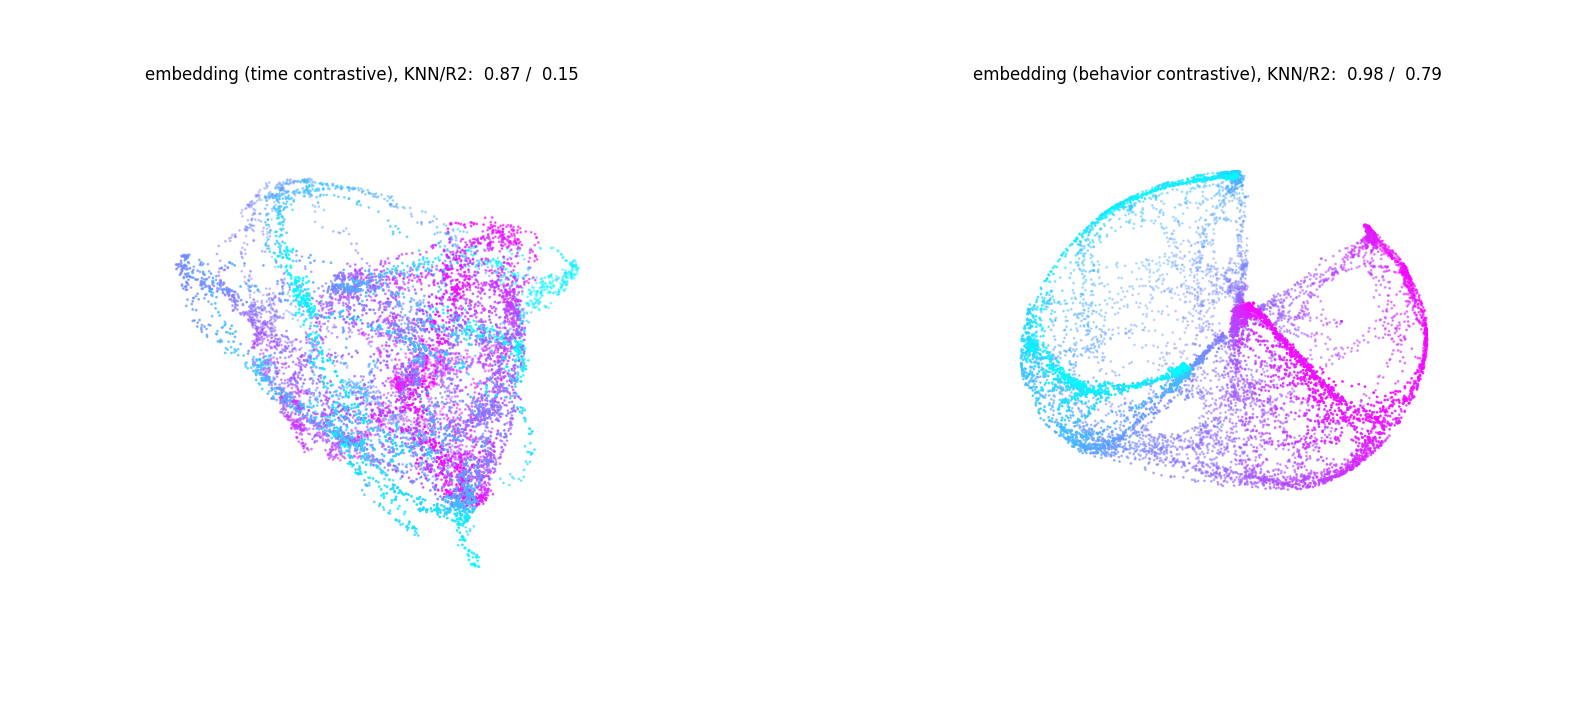

In [24]:
fig = plt.figure(figsize=(20, 15))

idx0_behavior, idx1_behavior, idx2_behavior = 0,1,2
idx0_time, idx1_time, idx2_time = 4,5,6
min_, max_ = 0, 10_000

ax1 = fig.add_subplot(121, projection='3d')
scatter1 = ax1.scatter(embedding[:, idx0_time][min_:max_],
                       embedding[:, idx1_time][min_:max_],
                       embedding[:, idx2_time][min_:max_],
                       c=position[:, 0][min_:max_], s=1, cmap="cool")
ax1.set_title(f'embedding (time contrastive), KNN/R2: {average_KNN_time: .2f} / {R2_time: .2f}', y=1.0, pad=-10)
ax1.set_axis_off()

ax2 = fig.add_subplot(122, projection='3d')
scatter2 = ax2.scatter(embedding[:, idx0_behavior][min_:max_],
                       embedding[:, idx1_behavior][min_:max_],
                       embedding[:, idx2_behavior][min_:max_],
                       c=position[:, 1][min_:max_], s=1, cmap="cool")
ax2.set_title(f'embedding (behavior contrastive), KNN/R2: {average_KNN_behavior: .2f} / {R2_behavior: .2f}', y=1.0, pad=-10)
ax2.set_axis_off()

plt.show()


## Compute attribution map, AUC and visualize it

In [27]:
attribution_split = 'train'
model = solver.model.to(device)
model.split_outputs = False
neural.requires_grad_(True)

method = cebra.attribution.init(
    name="jacobian-based",
    model=model,
    input_data=neural,
    output_dimension=model.num_output
    )

result = method.compute_attribution_map()

Computing inverse for jf with method lsq
Computing inverse for jf with method svd
Computing inverse for jf-convabs with method lsq
Computing inverse for jf-convabs with method svd


In [28]:
jf = abs(result['jf']).mean(0)
jfinv = abs(result['jf-inv-svd']).mean(0)
jfconvabsinv = abs(result['jf-convabs-inv-svd']).mean(0)

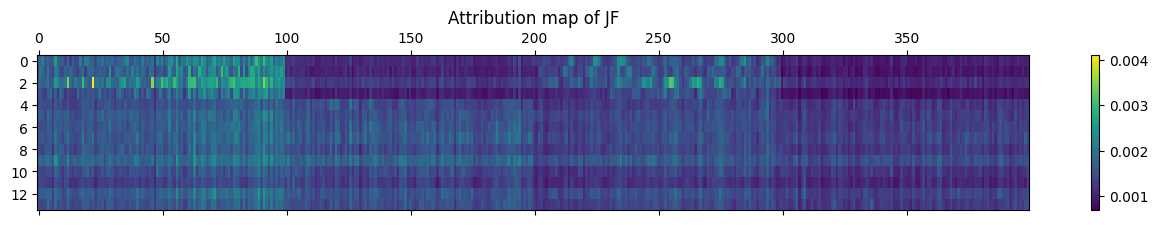

In [29]:
plt.matshow(jf, aspect="auto")
plt.colorbar()
plt.title("Attribution map of JF")
plt.show()

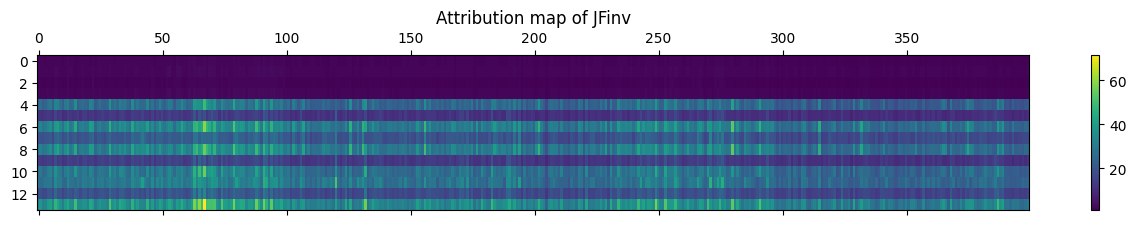

In [30]:
plt.matshow(jfinv, aspect="auto")
plt.colorbar()
plt.title("Attribution map of JFinv")
plt.show()

In [31]:
auc_jf = method.compute_attribution_score(jf, ground_truth_attribution)
auc_jfinv = method.compute_attribution_score(jfinv,  ground_truth_attribution)
auc_jfconvabsinv = method.compute_attribution_score(jfconvabsinv,  ground_truth_attribution)
print(f"auc_jf, {auc_jf: .2f}")
print(f"auc_jfinv, {auc_jfinv: .2f}")
print(f"auc_jfconvabsinv, {auc_jfconvabsinv: .2f}")

auc_jf,  0.94
auc_jfinv,  0.96
auc_jfconvabsinv,  0.18
